# QDC CALIBRATION

In this notebook we obtain the ASICs qdc calibration using the tpulse.

We obtain a curve efine vs integration window, so that when taking real data we can correct the efine obtained for any integration window.

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pylab as plt
%matplotlib inline
import os

In [2]:
import sys 
sys.path.append("/home/nsalor/Software/ANTEA")

In [3]:
from antea.preproc.io              import get_files
from antea.preproc.io              import read_run_data
from antea.preproc.tdc_corrections import compute_integration_window_size
from antea.preproc.qdc_corrections import correct_efine_wrap_around
from antea.preproc.qdc_calibration import compute_qdc_calibration_using_mode
from antea.preproc.qdc_calibration import plot_all_channels
from antea.preproc.qdc_calibration import process_qdc_calibration_run

# Process data

In [4]:
run_number = 12384

In [5]:
pd.read_hdf('/analysis/12384/hdf5/data/run_12384_0000_trigger1_waveforms.h5', 'data', stop = 10000)

,evt_number,ctdaq,ct_data,card_id,tofpet_id,wordtype_id,channel_id,sensor_id,tac_id,tcoarse,ecoarse,tfine,efine
0,1,38148891,6,0,7,2,0,-1,1,6360,219,246,1010
1,2,38155971,6,0,7,2,0,-1,2,13386,77,316,1010
2,2,38155971,6,0,7,2,0,-1,3,20412,959,314,1010
3,2,38155971,6,0,7,2,0,-1,0,27438,817,328,1010
4,2,38155971,6,0,7,2,0,-1,1,34464,675,317,1010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,336,108198172,21,0,7,2,0,-1,0,42174,193,329,1010
9996,336,108198172,21,0,7,2,0,-1,1,49200,51,314,1010
9997,336,108198172,21,0,7,2,0,-1,2,56226,933,315,1010
9998,336,108198172,21,0,7,2,0,-1,3,63252,791,311,1010


The function below shows two plots. The first one shows the entries for each channel. The second one the entries for each integration window.

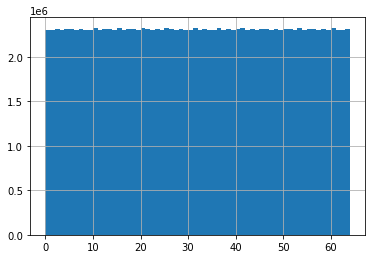

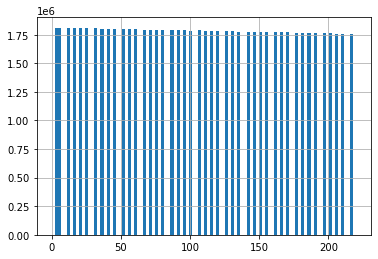

In [6]:
df_qdc = process_qdc_calibration_run(run_number, max_intg_w = 416, hist = True, folder = '/analysis/{run}/hdf5/data/')

In [7]:
df_qdc

,tofpet_id,channel_id,tac_id,intg_w,efine
0,7,0,0,0,0
1,7,0,0,6,0
2,7,0,0,11,0
3,7,0,0,16,0
4,7,0,0,21,0
...,...,...,...,...,...
21533,7,63,3,396,694
21534,7,63,3,401,694
21535,7,63,3,406,695
21536,7,63,3,411,695


**Create the expected windows to filter wrong values**

In [8]:
expected_windows = np.concatenate([[0], np.arange(6, 416, 5), [2000]])
expected_windows

array([   0,    6,   11,   16,   21,   26,   31,   36,   41,   46,   51,
         56,   61,   66,   71,   76,   81,   86,   91,   96,  101,  106,
        111,  116,  121,  126,  131,  136,  141,  146,  151,  156,  161,
        166,  171,  176,  181,  186,  191,  196,  201,  206,  211,  216,
        221,  226,  231,  236,  241,  246,  251,  256,  261,  266,  271,
        276,  281,  286,  291,  296,  301,  306,  311,  316,  321,  326,
        331,  336,  341,  346,  351,  356,  361,  366,  371,  376,  381,
        386,  391,  396,  401,  406,  411, 2000])

In [9]:
df_filtered = df_qdc[df_qdc.intg_w.isin(expected_windows)]

**Check max and min integration window size for each channel and tac to avoid wrong interpolations**

In [10]:
df_filtered.groupby(['channel_id', 'tac_id']).min().intg_w.unique()

array([0])

In [11]:
df_filtered.groupby(['channel_id', 'tac_id']).max().intg_w.unique()

array([2000])

We show the efine vs integration window curves for all channels:

([<matplotlib.axis.XTick at 0x7f70e373d280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

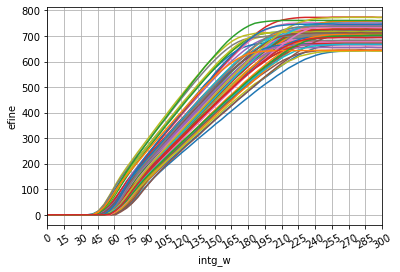

In [12]:
plot_all_channels(df_filtered, [0, 220])
plt.xlabel('intg_w')
plt.ylabel('efine')
plt.grid()
plt.xticks(np.linspace(0, 300, 21), rotation = 30)

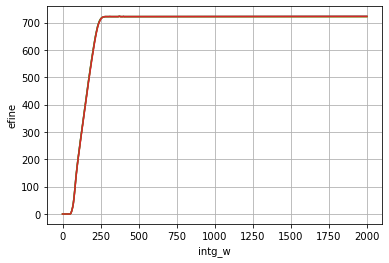

In [13]:
df_ch7 = df_filtered[(df_filtered['channel_id'] == 7)]
plt.plot(df_ch7[df_ch7['tac_id'] == 0].intg_w, df_ch7[df_ch7['tac_id'] == 0].efine, label = 'tac0')
plt.plot(df_ch7[df_ch7['tac_id'] == 1].intg_w, df_ch7[df_ch7['tac_id'] == 1].efine, label = 'tac1')
plt.plot(df_ch7[df_ch7['tac_id'] == 2].intg_w, df_ch7[df_ch7['tac_id'] == 2].efine, label = 'tac2')
plt.plot(df_ch7[df_ch7['tac_id'] == 3].intg_w, df_ch7[df_ch7['tac_id'] == 3].efine, label = 'tac3')
#plt.xlim(0, 300)

plt.xlabel('intg_w')
plt.ylabel('efine')
plt.grid()

## **Save data in file**

In [14]:
#df_filtered.to_hdf('qdc_calibration_cold_compressor_asic581_tofpet7_imirror25_version33_r12384.h5', 'data')